In [2]:
#Run this cell twice to ensure all libraries are imported
from ROOT import *
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import numpy as np
import deepdish.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import keras
from keras.models import Sequential, load_model
from sklearn.externals import joblib
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import ks_2samp

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

2018-12-01 18:02:46.212923: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-12-01 18:02:47.192648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
totalMemory: 11.90GiB freeMemory: 11.74GiB
2018-12-01 18:02:47.192691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-12-01 18:02:47.466705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-12-01 18:02:47.466746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-12-01 18:02:47.466752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-12-01 18:02:47.467200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replic

In [4]:
data = TFile.Open("/home/minerva1993/public/v808/nosplit/ttHbb_PowhegPythia.root")
data2 = TFile.Open("/home/minerva1993/public/v808/nosplit/TTLJ_PowhegPythia_ttbb.root")
tree = data.Get("ttbbLepJets/tree")
tree2 = data2.Get("ttbbLepJets/tree")

In [5]:
def tree_to_df(tree, branch_names=[], index_name='', drop_roofit_labels=False):
    if tree is None:
        return None

    branch_list = tree.GetListOfBranches()
    all_branch_names = [branch_list.At(i).GetName() for i in range(branch_list.GetEntries())]
    if len(branch_names) == 0:
        branch_names = all_branch_names
    for bn in branch_names[:]:
        if bn not in all_branch_names:
            branch_names.remove(bn)
        if drop_roofit_labels:
            if bn.endswith('_lbl'):
                branch_names.remove(bn)

    arrs = tree2array(tree, branch_names, start = 0, stop = 40000)
    #Stop at 40000 data points
    df = pd.DataFrame(arrs)

    if len(index_name) == 0:
        for col in df.columns:
            if col.startswith('__index__'):
                index_name = col
                break
    if len(index_name):
        try:
            df[index_name] = df[index_name].astype(np.int32)
            df.set_index(index_name, inplace=True)
        except BaseException:
            pass

    if drop_roofit_labels:
        df.columns = [col.replace('_idx', '') for col in df.columns]

    n_tree = tree.GetEntries()
    n_df = len(df.index)

    return df 

In [6]:
dftree = tree_to_df(tree)
#dftree - ttHbb
dftree_bg = tree_to_df(tree2)
#dftree_bg - TTLJ

In [36]:
def convert_pic(df):
    
    pics = []
    
    for i in range(len(df['lepton_SF'])):
        
        features = ['jet_pT','jet_eta','jet_E','jet_CvsB','jet_phi']
        jet_len = len(df['jet_CSV'][i])
        pic = []
        
        for t in range(jet_len):
            jet_info = []
            for k in features:
                jet_info.append(df[k][i][t])
            pic.append(jet_info)
        
        pics.append(np.array(pic))
    
    return pics

In [37]:
pic_signal = np.array(convert_pic(dftree))

In [62]:
def pic_display(pic):
    
    transformed_pic = []
    
    for t in pic:
        image = [[0 for i in range(len(t[0]))] for m in range(len(t))]
        for x in range(len(t)):
            for y in range(len(t[0])):
                image[x][y] = np.uint8(255 * (t[x][y] - t.min()) / (t.max() - t.min()))
        
        transformed_pic.append(np.array(image))
    
    return transformed_pic

In [63]:
transformed_pic_signal = pic_display(pic_signal)

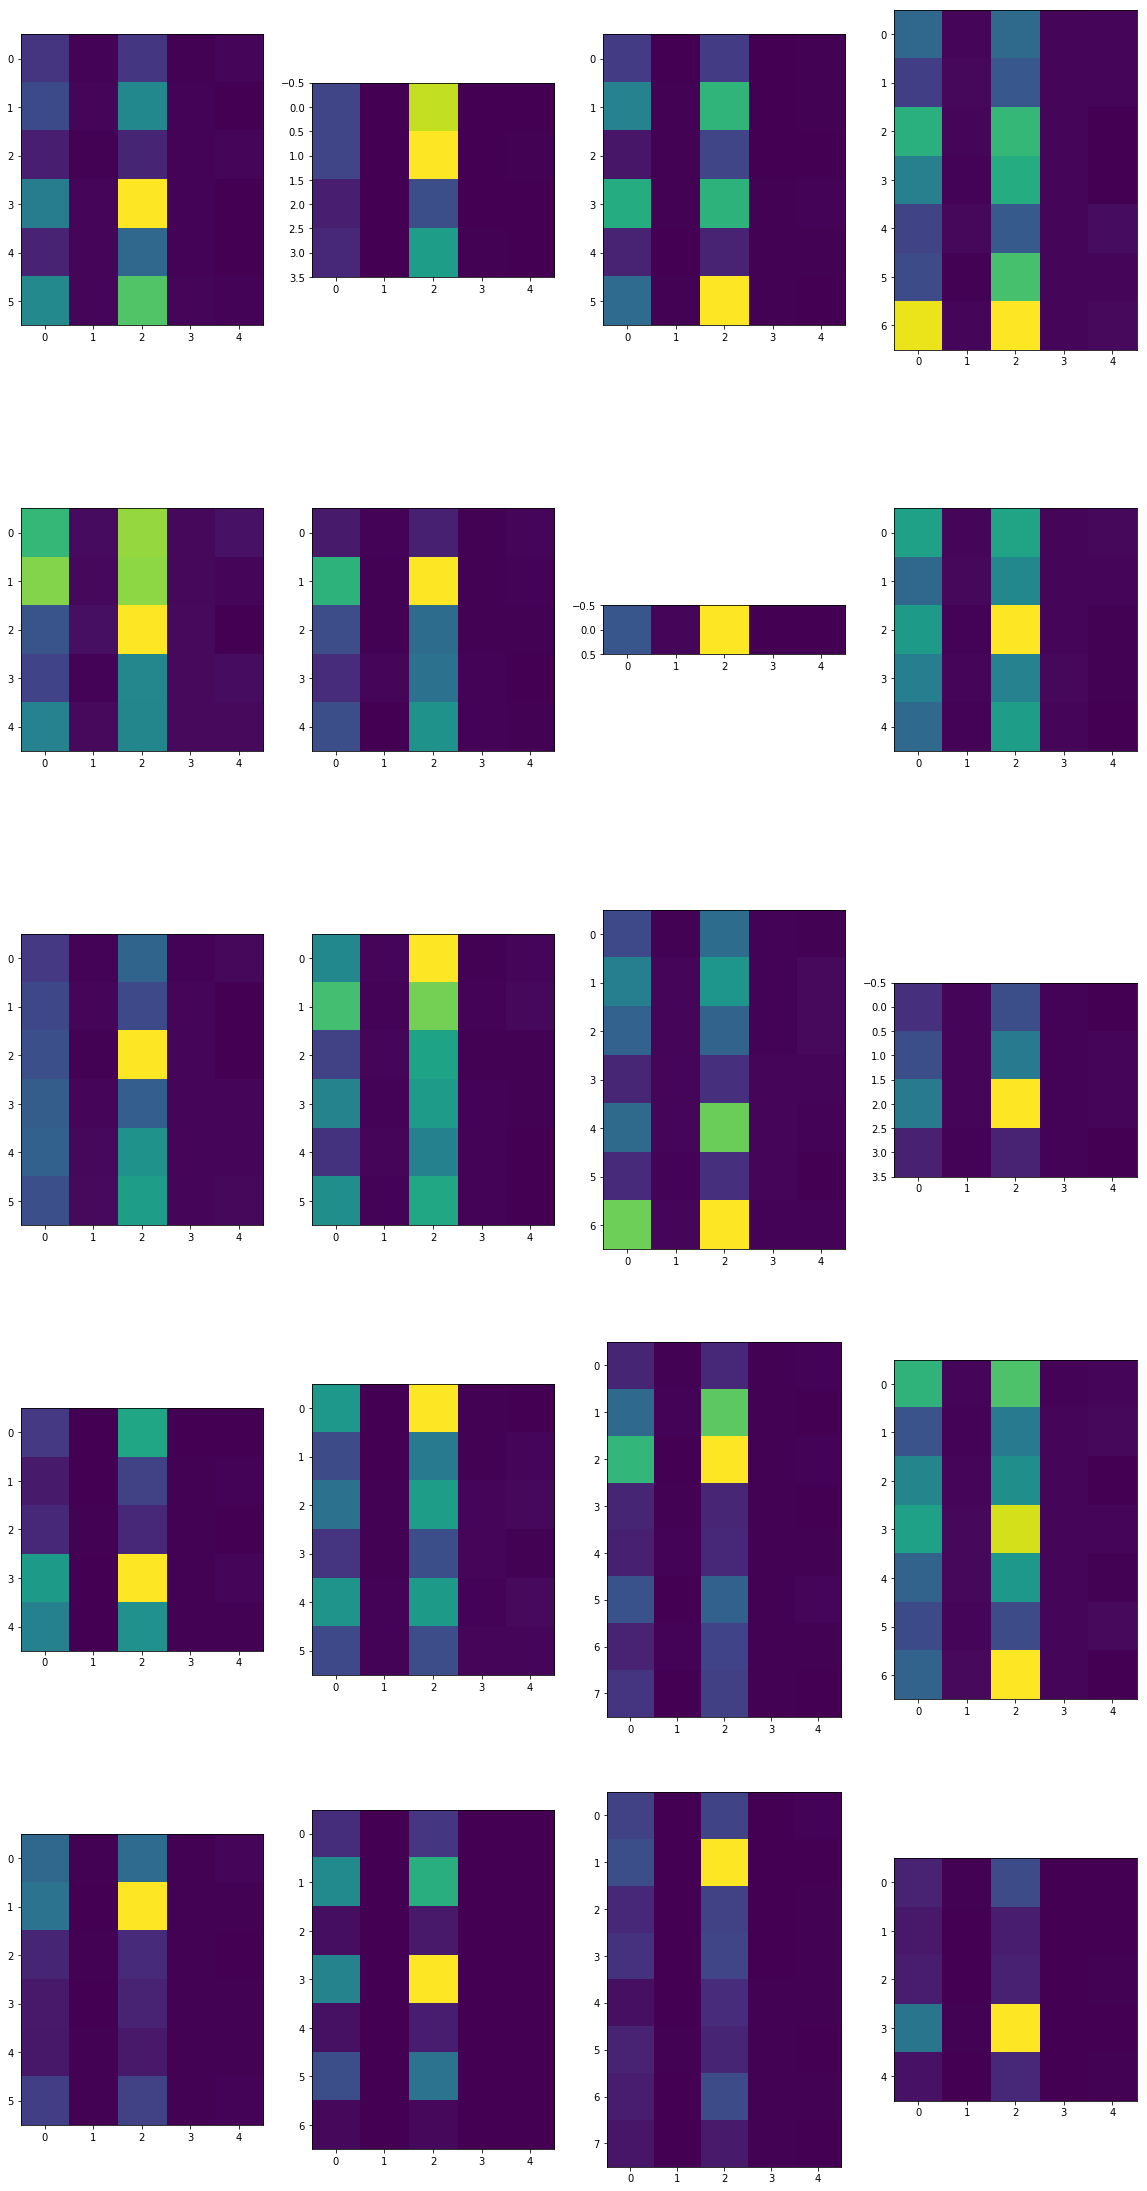

In [68]:
from matplotlib.pyplot import imshow

fig = plt.figure(figsize=(20,40))
axes = fig.subplots(nrows=5, ncols=4)
c_num = 0

for ax in axes:
    for row in ax:
        row.imshow(transformed_pic_signal[c_num])
        c_num += 10

plt.show()